# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

## Rubric points
#### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one. You can submit your writeup as markdown or pdf. Here is a template writeup for this project you can use as a guide and a starting point.

You're reading it!


### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for initial preprocessing of the data can be found in `src/data_loading.py`. It contains reference to the location of the `vehicle` and `non-vehicle` images, reading them with `mpimg` and computing labels and train/test indices. 

Output of this step is  `indices_train`, `indices_test`, `y_train`, `y_test`.

I have also loaded a test frame from the test video.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import time

In [2]:
from src.data_loading import *

In [3]:
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

t=time.time()
cars_img, notcars_img = read_images(cars, notcars)
indices_train, indices_test, y_train, y_test, rand_state = xy_train_test(cars_img, notcars_img)
t2 = time.time()
print(round(t2-t, 2), 'seconds to load')
print(len(y_train) + len(y_test), 'observations')

12.42 seconds to load
17760 observations


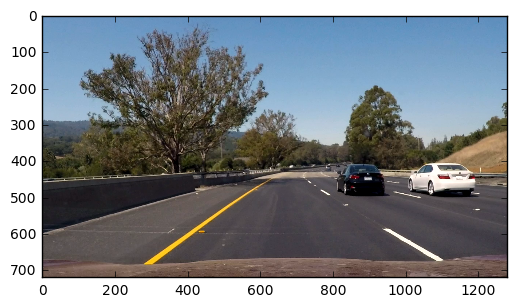

In [4]:
vidcap = cv2.VideoCapture('test_video.mp4')
success, image = vidcap.read()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

Code for the feature extraction can be found in `src/feature_creation.py`. The main functions there are:

* `extract_features` computes features for individual image. It calls `color_hist` `bin_spatial` and `get_hog_features_per_channel`. It also iterates over input color spaces using `convert_color` to compute all of the above features for each color space.
* `create_feature_matrix` iterates over the input images to compute entire feature matrix and splits it into train and test

I have mainly experimented with a different feature spaces to get the best possible combination of speed and performance. Final feature space contained features in **YCrCb** color space.

In [5]:
from src.feature_creation import *

In [6]:
t=time.time()
X_train, X_test = create_feature_matrix(cars_img + notcars_img, indices_train, indices_test)
t2 = time.time()
print(round(t2-t, 2), 'seconds to featurize')
print(X_train.shape, 'shape of training data')

64.72 seconds to featurize
(14208, 8460) shape of training data


#### 2. Explain how you settled on your final choice of HOG parameters.

I used the performance from SVM and the time to process 1 image as the variables to optimize and settled on **LUV** and **HLS** color spaces.

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

Folowing cells contain the definition of the classifier. I have used the `Pipeline API` from scikit-learn to define and fit the entire pipeline. The reason for that is that I could then test different combinations of parameters for the entire pipeline at once.

For the pipeline I have used `StandardScaler` for normalization and `LinearSVC` for classification. For the chosen color spaces I have achieved `99.5%` accuracy.

I then subsequently saved the fitted model (using `pickle`) to reuse it for the later parts of the project.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()
svc = LinearSVC()
pipeline = Pipeline([('scaler', scaler), ('svc', svc)])

In [9]:
t=time.time()
pipeline.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t), 'Seconds to train')

12 Seconds to train


In [10]:
print('Test Accuracy of classified = ', pipeline.score(X_test, y_test))
t=time.time()
n_predict = 10
print('My SVC predicts: ', pipeline.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of classified =  0.991554054054
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
0.00263 Seconds to predict 10 labels with SVC


In [11]:
import pickle
dict_save = {
    "pipeline": pipeline,
}
pickle.dump(dict_save, open("pipeline.p", "wb"))

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

File `src/window_processing.py` contains the functions I used in this section. The main function are:
* `slide_window` where I do a sliding window search for a given window size
* `slide_window_scales` where I call `slide_window` for different scales
* `search_windows` that takes as parameters
    * `windows` defined by `slide_window_scales`
    * the classification `pipeline` (scaler+SVM) 
    * and the function `feature_fn` which can be any feature-extracting function
    
Then for every image defined by `windows` I use `feature_fn` to extract features and `pipeline` to classify.

To check the appropriate scales I was looking at several test images and was trying to find `min` and `max` of the windows I need to look at. For the overlap I was looking at the detection rate of the objects.

#### 2. Show some examples of test images to demonstrate how your pipeline is working. What did you do to optimize the performance of your classifier?



Below you can find an output from the 1st frame in `test_video.mp4`. I was mainly optimizing the scales of windows and the color spaces, looking at the predictive performance and speed tradeoff.

In [12]:
from src.window_processing import *

In [13]:
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

3 seconds to predict image


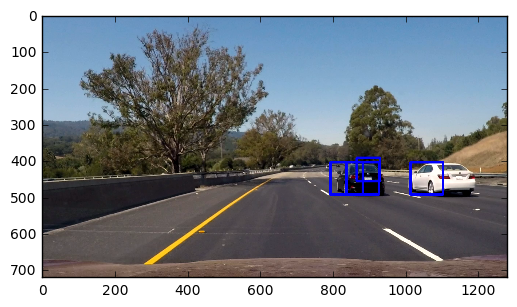

In [14]:
y_start_stop_new = [image.shape[0] // 2, image.shape[0]]

t=time.time()
windows = slide_window_scales(image, sample = None,
                              x_start_stop=[None, None], y_start_stop=y_start_stop_new,
                              xy_window=(128, 128), xy_overlap=(0.5, 0.5))
hot_windows = search_windows(image, windows, pipeline, extract_features)
t2 = time.time()
print(round(t2-t), 'seconds to predict image')
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

### Video Implementation

#### 1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

The video outputs can be found under `output_images/annotated_test_video.mp4` and  `output_images/annotated_project_video.mp4`

#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.



The main logic for this section is contained in `ObjectDetector` class from `src/object_detector.py`

* The entry point is `process_image()` function, which uses methods to extract and classify windows described above. For each frame of the vide I recorderd the position of positive classifications and used them to compute a heatmap using `add_heat` function from `src/window_processing.py`
* In order to get rid of false positives on a given frame, `ObjectDetector` caches the last 5 heatmaps and after every iteration it computes an average heatmap using `average_heatmaps`
* This heatmap is then thresholded to identify vehicle positions. I then used scipy.ndimage.measurements.label() to identify individual blobs in the heatmap. The logic for that can be found in `get_current_objects`
* I used the output from previous point to overlay bounding boxes on each frame on the video using `draw_current_objects()` function.

The main parameters I tested here is the window over which I'm averaging the heatmaps and the threshold (to find a tradeoff between robustness and "eagerness" to detect new objects).

I have also added the lane lines from the previous project.

Below you can find usage of those functions individually as well as the single iteration of `ObjectDetector`.

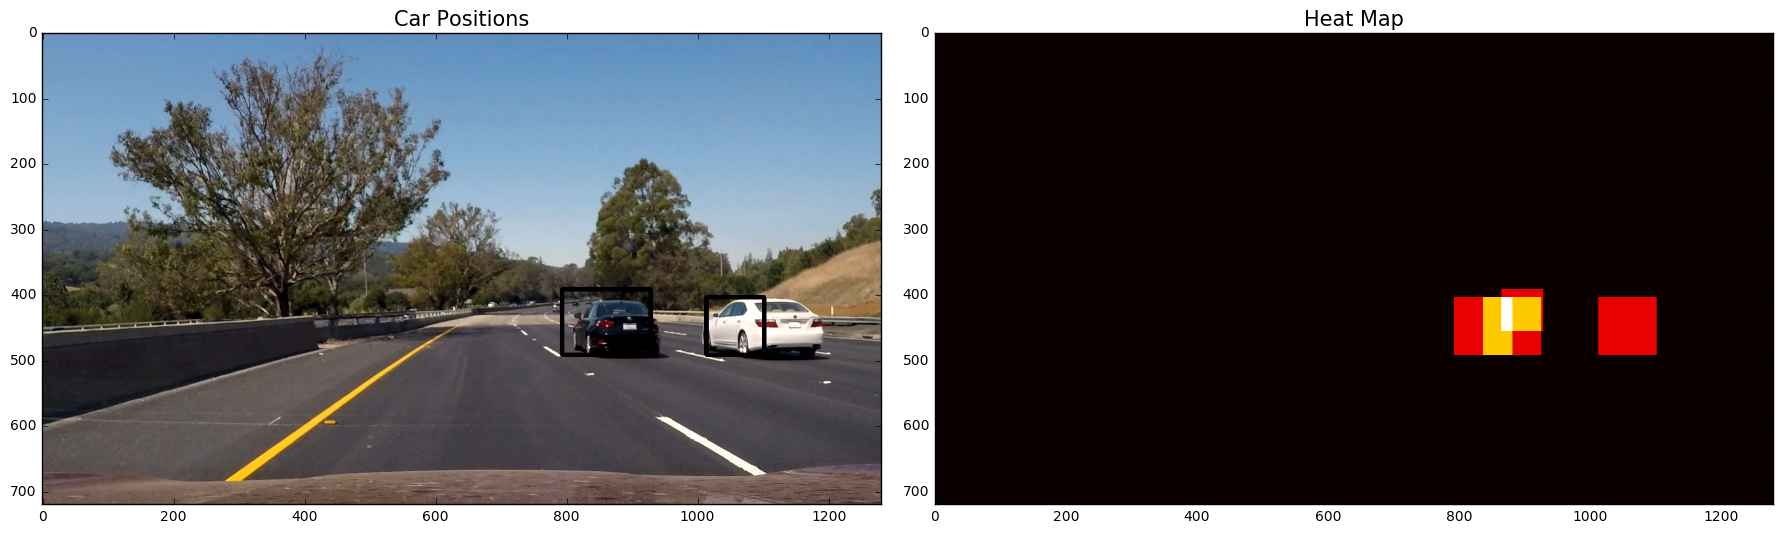

In [15]:
from scipy.ndimage.measurements import label

# Initial heatmap 
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 0.5)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)

draw_img = draw_labeled_bboxes(np.copy(image), labels)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=15)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=15)

In [16]:
from src.object_detector import ObjectDetector

In [17]:
object_detector = ObjectDetector(pipeline, extract_features)

In [18]:
object_detector.process_image(image)

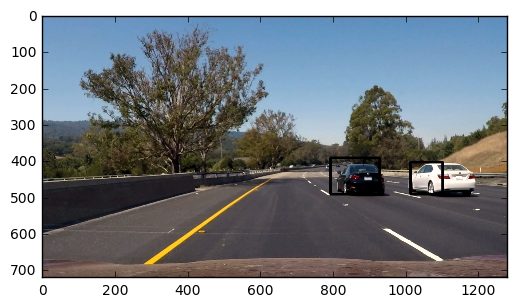

In [19]:
plt.imshow(object_detector.draw_current_objects(image))

I have then used this object to process the video. Since the images of the video were on a different scale compared to training images I needed to rescale.

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

In [21]:
object_detector = ObjectDetector(pipeline, extract_features)

def process_image(img):
    img_scaled = img.astype(np.float32)/255
    object_detector.process_image(img_scaled)
    annotated = object_detector.draw_current_objects(img)
    return annotated

In [22]:
annotated_output = 'output_images/annotated_test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(annotated_output, audio=False)

[MoviePy] >>>> Building video output_images/annotated_test_video.mp4
[MoviePy] Writing video output_images/annotated_test_video.mp4


 97%|█████████▋| 38/39 [01:35<00:02,  2.62s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/annotated_test_video.mp4 

CPU times: user 3min 3s, sys: 2.47 s, total: 3min 6s
Wall time: 1min 37s


In [23]:
annotated_output = 'output_images/annotated_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(annotated_output, audio=False)

[MoviePy] >>>> Building video output_images/annotated_project_video.mp4
[MoviePy] Writing video output_images/annotated_project_video.mp4


100%|█████████▉| 1260/1261 [54:14<00:03,  3.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/annotated_project_video.mp4 

CPU times: user 1h 42min 36s, sys: 1min 23s, total: 1h 44min
Wall time: 54min 16s


In [ ]:
# process a 5 second clip from the 25-30 second mark
my_clip = VideoFileClip("project_video.mp4").subclip(25, 30)

In [24]:
# And to create an animated gif from a clip you can use write_gif...

my_clip = VideoFileClip("output_images/annotated_project_video_with_lines.mp4").resize(width=320)
my_clip.subclip(28,30).write_gif("sample.gif", fps=25)


[MoviePy] Building file sample.gif with imageio


 98%|█████████▊| 50/51 [00:04<00:00, 12.50it/s]


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

The main issue with the implementation is the classification and window extraction speed. There are two possible steps here:
* define a more compact and efficient feature set 
* iterate over search area in a smarter way. 
    * Randomly sample image locations according to the probabilities defined by current hashmap (that way you mainly look at the already discovered cars)
    * Compute HOG features only once and for every window find the relevant features. Here I didn't go this route on purpose to separate concerns between window detection and feature detection.